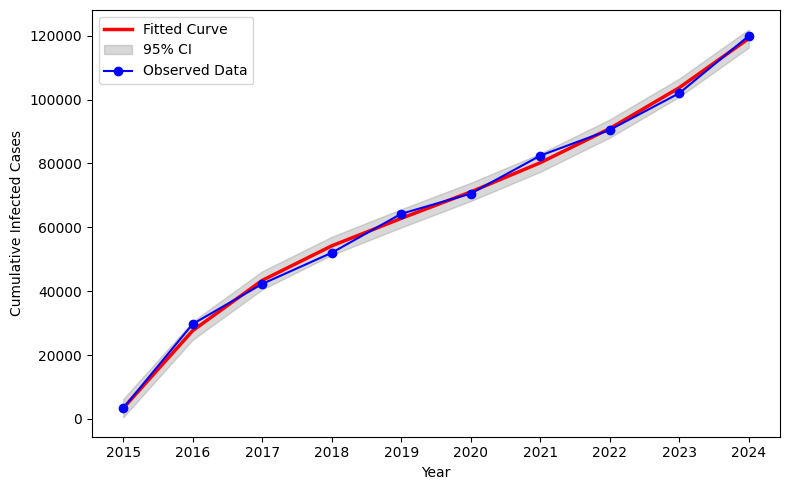

Estimated parameters:
0.46312, 0.93459, 0.76959, 0.28012, 0.54376, 0.10259, 0.48077, 0.74591


<Figure size 640x480 with 0 Axes>

In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v, C = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869

    dS_udt = Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt =  - ((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v
    dCdt = (1 - kappa) * epsilon * E_h


    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt, dCdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [90439692, 100000, 60000, 4469, 3342, 3000, 3751030000, 4963813800, 7802, 1300,3342]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 10]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/inidachikencumulative.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.46509, 0.93411, 0.76927, 0.27871, 0.54097, 0.12173, 0.48139, 0.74601]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [90439692, 100000, 60000, 4469, 3342, 3000, 3751030000, 4963813800, 7802, 1300,3342]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 10][:len(infected)]

# -------------------------
# Simple residual-based 95% CI
# -------------------------
residuals = infected - predicted_A
std_error = np.std(residuals)
ci_upper = predicted_A + 1.96 * std_error
ci_lower = predicted_A - 1.96 * std_error

# -------------------------
# Plot with CI
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.fill_between(df['Year'].dt.year, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(df['Year'].dt.year, infected, 'bo-', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))
plt.legend()
plt.tight_layout()
plt.show()

# Save the figure before showing it
plt.savefig('India_Cumulative_chiken.png', dpi=300, bbox_inches='tight')

print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))
